In [1]:
import numpy as np
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import importlib

import sklearn
#baseline linear regression
from sklearn import linear_model
#import sklearn.linear_model
#normalization
from sklearn import preprocessing
#train/test split
from sklearn.model_selection import train_test_split
#from sklearn.cross_validation import train_test_split
#metrics
from sklearn.metrics import mean_absolute_error

#dnn
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 
import DNN

#keras
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras import optimizers
from keras import regularizers

%matplotlib inline

Using TensorFlow backend.


In [2]:
import platform
print(platform.python_version())

3.6.2


In [2]:
importlib.reload(DNN)

<module 'DNN' from 'C:\\Users\\mircean\\git\\DeepLearning\\DNN.py'>

In [4]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:50% !important; }</style>"))

In [3]:
df1 = pd.read_csv(r'..\Zillow\properties_2016.csv')
print(df1.shape)
df2 = pd.read_csv(r'..\Zillow\train_2016_v2.csv')
print(df2.shape)


C:\Anaconda5\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning: Columns (22,32,34,49,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(2985217, 58)
(90275, 3)


In [24]:
#df2[df2.transactiondate >= '2016-10-15']
df2[df2.transactiondate < '2016-10-15'].shape
#max(df2.transactiondate)

(85670, 3)

In [4]:
df_train = df2.merge(df1, how='left', on='parcelid')

#revisit this fillna
df_train = df_train.fillna(0)

df_train['taxdelinquencyflag'] = df_train.taxdelinquencyflag.apply(lambda x: 1 if x == 'Y' else 0 )
df_train['fireplaceflag'] = df_train.hashottuborspa.astype(int)
df_train['hashottuborspa'] = df_train.hashottuborspa.astype(int)

#use all old data for training
#split the new data, 50% train, 50% dev
df_train_1 = df_train[df_train.transactiondate < '2016-10-15']
df_train_2 = df_train[df_train.transactiondate >= '2016-10-15']

train_index, dev_index = train_test_split(df_train_2.index, test_size=0.5, random_state=0)
df_train = pd.concat([df_train_1, df_train_2.loc[train_index]])
df_dev = df_train_2.loc[dev_index]

y_train = df_train.logerror.values
y_dev = df_dev.logerror.values

df_train = df_train.drop(['parcelid', 'logerror', 'transactiondate', 'propertyzoningdesc', 'propertycountylandusecode'], axis=1)
df_dev = df_dev.drop(['parcelid', 'logerror', 'transactiondate', 'propertyzoningdesc', 'propertycountylandusecode'], axis=1)

X_train = df_train.values
X_dev = df_dev.values

print(X_train.shape)
print(X_dev.shape)

(87972, 55)
(2303, 55)


In [5]:
#normalization - mean, var from train set, apply to dev set and test set
scaler = preprocessing.StandardScaler().fit(X_train)

X_train = scaler.transform(X_train)   
X_dev = scaler.transform(X_dev)

X_train_k = X_train
X_dev_k = X_dev
Y_train_k = y_train.reshape(y_train.shape[0], 1)
Y_dev_k = y_dev.reshape(y_dev.shape[0], 1)

X_train_my = X_train.T
X_dev_my = X_dev.T
Y_train_my = y_train.reshape(1, y_train.shape[0])
Y_dev_my = y_dev.reshape(1, y_dev.shape[0])



In [9]:
np.random.seed(0) # set a seed so that the results are consistent
regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)
y_pred = regr.predict(X_train)
print(mean_absolute_error(y_train, y_pred))
y_pred = regr.predict(X_dev)
print(mean_absolute_error(y_dev, y_pred))

0.0683074122879
0.0710661821951


In [6]:
class MyCallback(keras.callbacks.Callback):
    def __init__(self, verbose):
        self.verbose = verbose

    def on_epoch_begin(self, epoch, logs=None):
        pass

    def on_epoch_end(self, epoch, logs=None):
        if self.verbose != None and epoch % self.verbose == 0:
            print(datetime.datetime.now(), epoch, logs['loss'], logs['mean_absolute_error'], logs['val_mean_absolute_error']) 

In [ ]:
np.random.seed(0)
model = Sequential()

initializer = keras.initializers.he_normal()

regularizer = None

model.add(Dense(100, input_dim=X_train_k.shape[1], kernel_initializer=initializer, activation='relu', kernel_regularizer=regularizer))
model.add(Dense(20, kernel_initializer=initializer, activation='relu'))
#model.add(Dense(20, kernel_initializer=initializer, activation='relu'))
model.add(Dense(1, kernel_initializer=initializer))

#optimizer = optimizers.SGD(lr=0.05, momentum=0.9)
#optimizer = optimizers.RMSprop(lr=0.01)
optimizer = optimizers.Adam(lr=0.005)

model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mae'])

results_k = {'loss': [], 'eval0': []}

In [ ]:
initial_epoch = 0
epochs = 200
verbose = 0
verbose2 = 100
#batch_size = int(X_train_k.shape[0])
batch_size = 512

print('Start fit')
results_k_tmp = model.fit(X_train_k, Y_train_k, batch_size=batch_size, epochs=epochs, callbacks=[MyCallback(verbose2)], validation_data = (X_dev_k, Y_dev_k), verbose=verbose, initial_epoch=initial_epoch)

Y_predict_k = model.predict(X_train_k)
print(mean_absolute_error(Y_train_k, Y_predict_k))
Y_predict_k = model.predict(X_dev_k)
print(mean_absolute_error(Y_dev_k, Y_predict_k))

results_k['loss'] += results_k_tmp.history['loss']
results_k['eval0'] += results_k_tmp.history['mean_absolute_error']

Start fit
2017-10-05 15:17:23.591985 0 0.036054829343 0.0867392156789 0.0720607587438
2017-10-05 15:18:25.172653 100 0.0244661224359 0.0683504867731 0.0718659563552


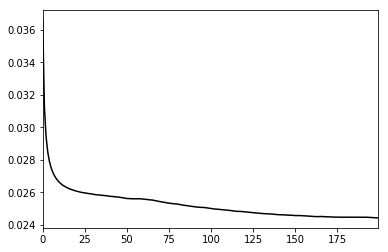

In [14]:
#plt.plot(results_k['loss'])
#plt.show()
df_loss_k = pd.DataFrame(results_k['loss'][0:])
df_loss_k[0].ewm(span=50).mean().plot(style='k')

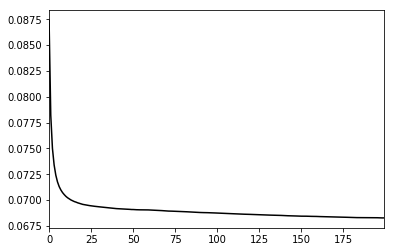

In [15]:
#plt.plot(results_k['eval0'])
#plt.show()
df_eval0_k = pd.DataFrame(results_k['eval0'][0:])
df_eval0_k[0].ewm(span=50).mean().plot(style='k')

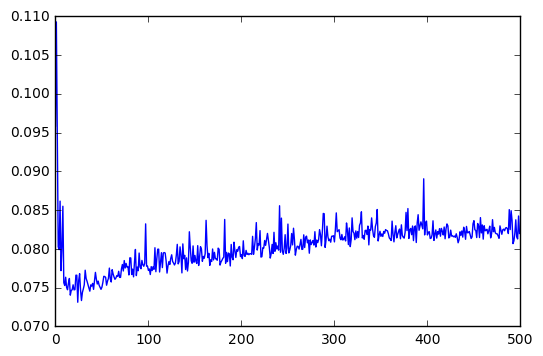

In [29]:
plt.plot(results_k.history['val_mean_absolute_error'])
plt.show()

In [128]:
importlib.reload(DNN)

<module 'DNN' from 'C:\\Users\\mircean\\git\\DeepLearning\\DNN.py'>

In [129]:
#random seed for parameters init and mini batch shuffle
np.random.seed(0)
dnn = DNN.DNN()
dnn.add_input_layer(X_train_my.shape[0])
dnn.add_layer(100, DNN.relu)
dnn.add_layer(20, DNN.relu)
#dnn.add_layer(20, DNN.relu)
dnn.add_layer(1, DNN.identity)
dnn.costfunction = DNN.mean_squared_error
dnn.init = 'He'
dnn.optimizer = 'Adam'
dnn.compile()

#eval_set = None
eval_set = [(X_train_my, Y_train_my), (X_dev_my, Y_dev_my)]
results_my = {'loss': [], 'eval0': [], 'eval1': []}

In [ ]:
learning_rate = 0.005
epochs = 10000
batch_size = 512
gradient_check=False
verbose = 1000

#eval_set = None
eval_set = [(X_train_my, Y_train_my), (X_dev_my, Y_dev_my)]
results_tmp = dnn.fit(X_train_my, Y_train_my, eval_set=eval_set, eval_metric='mae', learning_rate=learning_rate, epochs=epochs, batch_size=batch_size, gradient_check=gradient_check, verbose=verbose)
Y_predict_my = dnn.predict(X_train_my)
print(mean_absolute_error(np.reshape(Y_train_my, Y_train_my.shape[1]), np.reshape(Y_predict_my, Y_predict_my.shape[1])))
Y_predict_my = dnn.predict(X_dev_my)
print(mean_absolute_error(np.reshape(Y_dev_my, Y_dev_my.shape[1]), np.reshape(Y_predict_my, Y_predict_my.shape[1])))

results_my['loss'] += results_tmp['loss']
results_my['eval0'] += results_tmp['eval0']
results_my['eval1'] += results_tmp['eval1']

2017-10-04 10:18:01.445748 Cost after iteration 0 ['0.024006', '0.066045', '0.075726']


In [199]:
#dnn = DNN.DNN.load('file1.pickle')
#dnn.save('file1.pickle')
print(dnn.epochs, dnn.minibatches)

#350K lr=0.005

347575 59782764


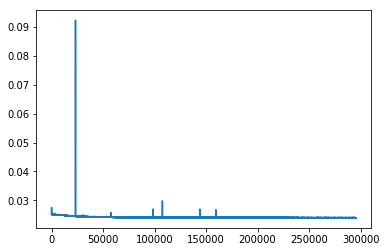

In [184]:
plt.plot(results_my['loss'][100:])
plt.show()

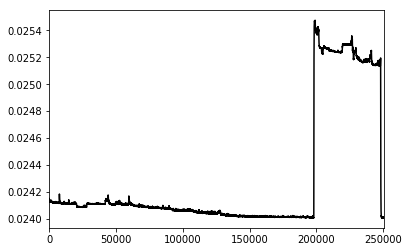

In [201]:
df_loss = pd.DataFrame(results_my['loss'][100000:])
df_loss[df_loss[0] > 0.5] = df_loss[0].mean()
#df_loss[0].plot()
df_loss[0].ewm(span=200).mean().plot(style='k')

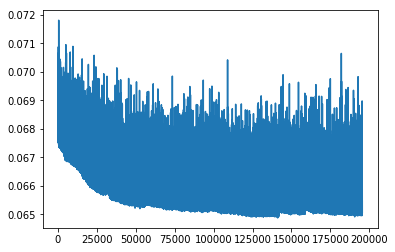

In [178]:
plt.plot(results_my['eval0'][100:])
plt.show()

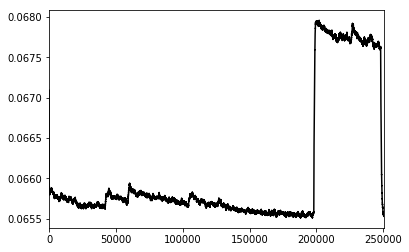

In [202]:
df_eval0 = pd.DataFrame(results_my['eval0'][100000:])
df_eval0[0].ewm(span=1000).mean().plot(style='k')

In [113]:
df_eval0[0].describe()

count    20.000000
mean      0.068786
std       0.000418
min       0.068378
25%       0.068556
50%       0.068653
75%       0.068921
max       0.070219
Name: 0, dtype: float64

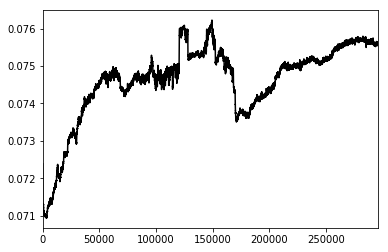

In [190]:
df_eval1 = pd.DataFrame(results_my['eval1'][100:])
df_eval1[0].ewm(span=200).mean().plot(style='k')

In [94]:
len(results_my['eval1'])

5000